# DE_ConditionCluster

In RNA sequencing analysis, we have 5 conditions in total, including as followings:
- pre-ampicillin lactose 0.1 mg/ml
- pre-ampcillin lactose 2.5 mg/ml
- pre-ampcillin lactose 50 mg/ml

Usering differential expression analysis of above dataset with comparison to *pre-ampcillin lactose 2.5 mg/ml* condition, we got 2 comparisons. Here, I'd like to compare these differential expression results and cluster them.

# 1. Import DE Results

Here we import both differential expression analysis files and the original gene count file. Here, we sequenced in totall 4211 genes, where GFP is a solo exogenous gene. we've got 25 biological replica in total. Comparing the normalized count data and the original count data, we observe the differences in replica number, where we droped 1 replica as outlier for this analysis. 

Note: all data is tidy.

In [51]:
# import packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# import differential expression data
de_01_vs_25_file = "../../5-16-20-OveralResults/2-With-amp/DE-CSVs/pre_lac25/pre_lac01_vs_pre_lac25.csv"
de_50_vs_25_file = "../../5-16-20-OveralResults/2-With-amp/DE-CSVs/pre_lac25/pre_lac50_vs_pre_lac25.csv"

pre_lac50_vs_pre_lac25 = pd.read_csv(de_50_vs_25_file, header=0, index_col=0).sort_index()
pre_lac01_vs_pre_lac25 = pd.read_csv(de_01_vs_25_file, header=0, index_col=0).sort_index()

In [53]:
# screen out data that are not significant 
pre_lac50_vs_pre_lac25.loc[pre_lac50_vs_pre_lac25.padj>0.05, "log2FoldChange"]=0.0
pre_lac01_vs_pre_lac25.loc[pre_lac01_vs_pre_lac25.padj>0.05, "log2FoldChange"]=0.0

In [54]:
pre_lac50_vs_pre_lac25.head(3)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
ECB_RS00005,282.768805,0.000000,0.330984,1.726862e-01,2.038443e-01
ECB_RS00010,414.621461,-2.484222,0.223234,1.178223e-29,6.528230e-28
ECB_RS00015,125.144424,-1.859210,0.235154,6.392272e-16,6.534970e-15


In [55]:
len(pre_lac50_vs_pre_lac25), len(pre_lac01_vs_pre_lac25)

(4490, 4490)

In [56]:
# import original gene count data
ori_count = pd.read_csv("countdata.txt", header=0, index_col=0, sep="\t")
ori_count.head(3)

,T1-L50-02,OD-L25-01,OD-L01-01,T1-L50-03,T1-L50-01,OD-L25-02,T0-L01-08,OD-L01-02,OD-L25-03,T1-L50-04,...,T0-L01-02,T0-L25-14,T1-L50-08,T1-L50-09,T0-L25-15,T0-L01-05,T0-L25-10,T0-L01-12,T0-L01-06,T0-L25-13
ECB_RS00005,51.0,388.0,137.0,24.0,43.0,239.0,355.0,76.0,453.0,64.0,...,89.0,969.0,17.0,31.0,689.0,439.0,3.0,234.0,424.0,520.0
ECB_RS00010,999.0,4459.0,44.0,750.0,771.0,3179.0,27.0,16.0,2578.0,1066.0,...,6.0,761.0,558.0,1007.0,579.0,111.0,4.0,15.0,79.0,642.0
ECB_RS00015,274.0,797.0,17.0,240.0,222.0,1015.0,11.0,8.0,677.0,297.0,...,3.0,192.0,209.0,357.0,153.0,46.0,3.0,9.0,33.0,166.0


In [57]:
# import normalized gene count data
norm_count = pd.read_csv("../../5-16-20-OveralResults/2-With-amp/DE-CSVs/norm_count.csv", header=0, index_col=0)
norm_count.head(3)

,pst_lac50_01,pre_lac25_02,pre_lac01_03,pst_lac50_04,pst_lac50_05,pre_lac25_06,pre_lac01_07,pre_lac01_08,pre_lac25_09,pst_lac50_10,...,pst_lac01_31,pre_lac01_32,pre_lac25_33,pst_lac50_34,pst_lac50_35,pre_lac25_36,pre_lac01_37,pre_lac01_38,pre_lac01_39,pre_lac25_40
ECB_RS00005,14.164662,178.501030,305.053802,8.365708,14.767812,143.576313,745.874487,473.835395,310.037118,16.217577,...,217.523183,621.658801,717.073636,7.377962,8.310966,672.231734,480.087030,916.141222,601.209884,454.082584
ECB_RS00010,277.460729,2051.381679,97.973484,261.428387,264.790301,1909.745185,56.728482,99.754820,1764.405496,270.124012,...,188.241216,41.909582,563.150709,242.170767,269.972351,564.908816,121.388748,58.727001,112.017879,560.617344
ECB_RS00015,76.100340,366.663198,37.853391,83.657084,76.243122,609.748777,23.111604,49.877410,463.344655,75.259692,...,93.074824,20.954791,142.082702,90.705538,95.710158,149.276423,50.305247,35.236201,46.792279,144.957133


In [58]:
norm_count.shape

(4490, 40)

### 1.1 Prepare Differential Analysis Results for Clustering

Considering multiple different clustering methods, as shown in following link, I choose RBS SVM for clustering the replica data:
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

For preparing for clustering, I'd like to set each column of *norm_count* as a list, and label them based on conditions. 

In [59]:
X = np.asarray(norm_count.transpose())
X[0:3]

array([[1.41646618e+01, 2.77460729e+02, 7.61003401e+01, ...,
        5.86028167e+01, 1.31370295e+02, 2.77738468e+00],
       [1.78501030e+02, 2.05138168e+03, 3.66663198e+02, ...,
        1.19614092e+01, 4.33463067e+03, 0.00000000e+00],
       [3.05053802e+02, 9.79734838e+01, 3.78533915e+01, ...,
        0.00000000e+00, 4.72054059e+03, 6.68001026e+00]])

Here we observe that for different genes, there scale are different. Thus lets normalize the dataset so that each dimentsion lies between 0 and 1, so they have equal weright in the clustering process. 

In [60]:
normalized_X = preprocessing.normalize(X)
normalized_X[:3]

array([[2.01794363e-03, 3.95279546e-02, 1.08415011e-02, ...,
        8.34874717e-03, 1.87154380e-02, 3.95675221e-04],
       [8.07347786e-04, 9.27825716e-03, 1.65839223e-03, ...,
        5.41006248e-05, 1.96052341e-02, 0.00000000e+00],
       [1.41608812e-04, 4.54802025e-05, 1.75718964e-05, ...,
        0.00000000e+00, 2.19131885e-03, 3.10092290e-06]])

In [61]:
y = norm_count.columns.str.slice(0,9)
y.unique()

Index(['pst_lac50', 'pre_lac25', 'pre_lac01', 'pst_lac01', 'pre_lac50'], dtype='object')

# 2. Heirarchical Clustering

In [62]:
# Hierarchical clustering
# Ward is the default linkage algorithm, so we'll start with that
ward = AgglomerativeClustering(n_clusters=5)
ward_pred = ward.fit_predict(normalized_X)

In [63]:
ward_ar_score = adjusted_rand_score(y, ward_pred)
ward_ar_score

0.559675550405562

In [64]:
y

Index(['pst_lac50', 'pre_lac25', 'pre_lac01', 'pst_lac50', 'pst_lac50',
       'pre_lac25', 'pre_lac01', 'pre_lac01', 'pre_lac25', 'pst_lac50',
       'pst_lac50', 'pst_lac50', 'pre_lac25', 'pst_lac50', 'pst_lac50',
       'pre_lac25', 'pst_lac01', 'pst_lac01', 'pst_lac01', 'pst_lac01',
       'pst_lac01', 'pre_lac50', 'pre_lac50', 'pre_lac50', 'pre_lac50',
       'pre_lac50', 'pre_lac50', 'pre_lac50', 'pst_lac01', 'pre_lac50',
       'pst_lac01', 'pre_lac01', 'pre_lac25', 'pst_lac50', 'pst_lac50',
       'pre_lac25', 'pre_lac01', 'pre_lac01', 'pre_lac01', 'pre_lac25'],
      dtype='object')

In [65]:
ward.labels_

array([1, 4, 0, 1, 1, 4, 0, 0, 4, 1, 1, 3, 4, 1, 3, 4, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2])

# 3. Dendrogram visualization with scipy

In [66]:
# Specify the linkage type. Scipy accepts 'ward', 'complete', 'average', as well as other values
# Pick the one that resulted in the highest Adjusted Rand Score
linkage_type = 'ward'

linkage_matrix = linkage(normalized_X, linkage_type)
linkage_matrix[:3]

array([[1.10000000e+01, 1.40000000e+01, 1.71520036e-02, 2.00000000e+00],
       [3.20000000e+01, 3.50000000e+01, 3.37878753e-02, 2.00000000e+00],
       [1.70000000e+01, 1.80000000e+01, 3.81967927e-02, 2.00000000e+00]])

In [67]:
name_replace = {
        "pre_": "",
        "lac01_": "Starving ",
        "lac25_": "Moderate ",
        "lac50_": "Toxic ",
        "pst_": "amp " }
sample_names = norm_count.columns.to_list()
i = 0
while i<len(sample_names):
    name = sample_names[i]
    for word, replace_word in name_replace.items():
        name = name.replace(word, replace_word)
        sample_names[i] = name
    i = i+1
sample_names

['amp Toxic 01',
 'Moderate 02',
 'Starving 03',
 'amp Toxic 04',
 'amp Toxic 05',
 'Moderate 06',
 'Starving 07',
 'Starving 08',
 'Moderate 09',
 'amp Toxic 10',
 'amp Toxic 11',
 'amp Toxic 12',
 'Moderate 13',
 'amp Toxic 14',
 'amp Toxic 15',
 'Moderate 16',
 'amp Starving 17',
 'amp Starving 18',
 'amp Starving 19',
 'amp Starving 20',
 'amp Starving 21',
 'Toxic 22',
 'Toxic 23',
 'Toxic 24',
 'Toxic 25',
 'Toxic 26',
 'Toxic 27',
 'Toxic 28',
 'amp Starving 29',
 'Toxic 30',
 'amp Starving 31',
 'Starving 32',
 'Moderate 33',
 'amp Toxic 34',
 'amp Toxic 35',
 'Moderate 36',
 'Starving 37',
 'Starving 38',
 'Starving 39',
 'Moderate 40']

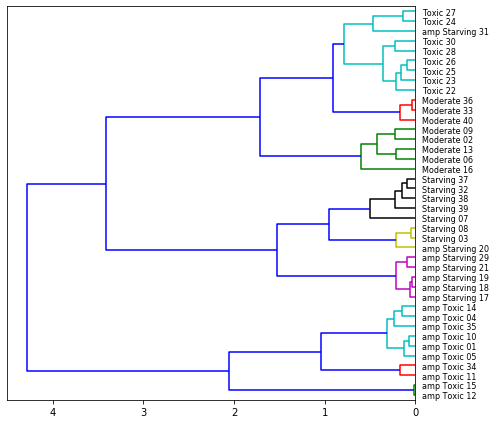

In [68]:
plt.figure(figsize=(7,6))

# plot using 'dendrogram()'
den = dendrogram(linkage_matrix, 
           labels=sample_names, 
           orientation='left',
           color_threshold=0.89)
plt.tight_layout()
plt.savefig("HelpPlots/replicacluster.pdf", dpi=200)
plt.show()

# 4. Condition similarity

### 4.1 Introduce to similarity measures
Five frequently used metric for measuring similarity are shown as following. 
Similarity based measures:
- Pearson's correlation coefficient
- Spearman's correlation coefficient
- Kendall's Tau

Diatance based measures:
- Euclidean Distance
- Manhattan Distance

### 4.2 Plot heatmap by cluster
We are using the same "ward" link for cluster calculation.

In [69]:
# Create dataframe 
fcdf = pd.concat(
    [
        pre_lac50_vs_pre_lac25["log2FoldChange"],
        pre_lac01_vs_pre_lac25["log2FoldChange"]
    ],
    join='outer', axis=1)
fcdf.columns = ['pre_lac50_vs_pre_lac25', 'pre_lac01_vs_pre_lac25']
fcdf.head(3)

,pre_lac50_vs_pre_lac25,pre_lac01_vs_pre_lac25
ECB_RS00005,0.000000,0.695844
ECB_RS00010,-2.484222,-3.847213
ECB_RS00015,-1.859210,-3.057420


In [70]:
fcdf.describe()

,pre_lac50_vs_pre_lac25,pre_lac01_vs_pre_lac25
count,4490.000000,4490.000000
mean,0.485330,0.334338
std,1.617664,2.234031
min,-5.644499,-8.086858
25%,-0.619263,-1.047055
50%,0.000000,0.000000
75%,1.744059,1.817703
max,8.094750,9.176790


In [71]:
fcdf = fcdf.fillna(0)

/Users/huijing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


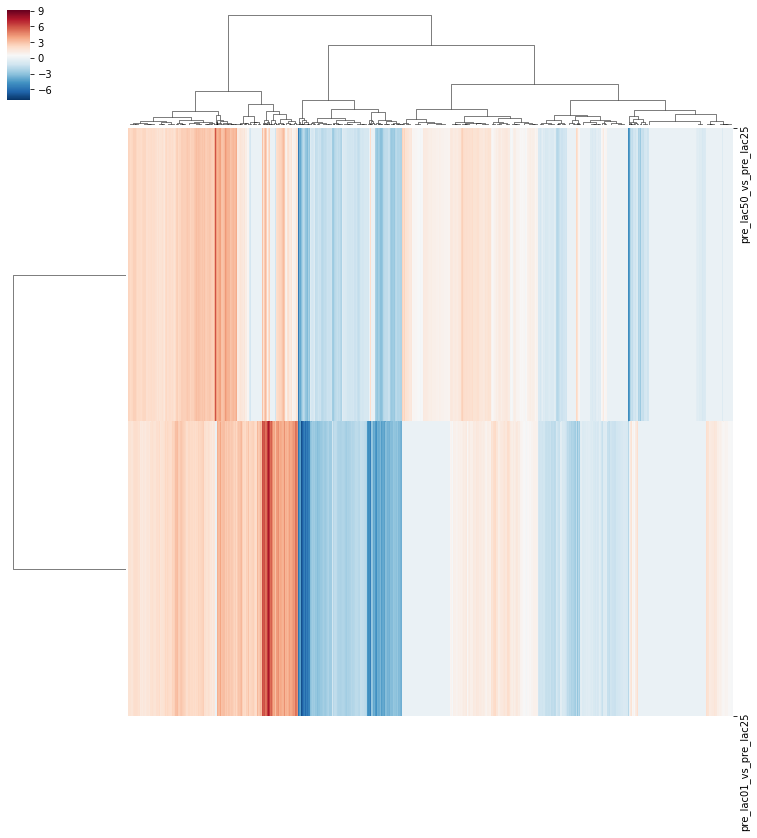

In [72]:
import seaborn as sns

sns.clustermap(fcdf.transpose(), figsize=(13,13), cmap='RdBu_r', method='ward', xticklabels=False)
plt.tight_layout()
plt.savefig("HelpPlots/conditioncluster_ticks.pdf", dpi=200)
plt.show()

/Users/huijing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


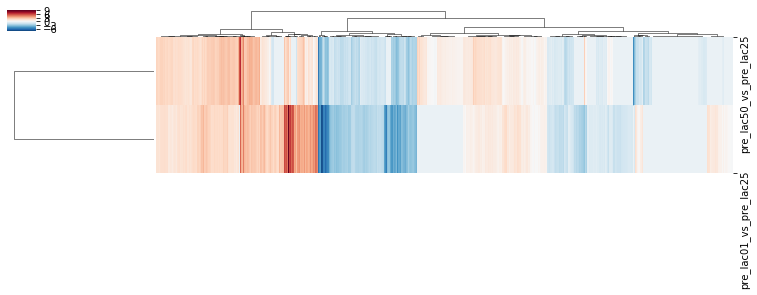

In [73]:
sns.clustermap(fcdf.transpose(), figsize=(13,3), cmap='RdBu_r', method='ward', xticklabels=False)
plt.tight_layout()
plt.savefig("HelpPlots/conditioncluster.pdf", dpi=200)
plt.show()